# Module 4: Autograded Assignment

### Outline:
**Here are the objectives of this assignment:**

1. Review skills in data cleaning and preparation.
2. Create training and test sets for model predictions.
3. Predict on training and test sets.
4. Learn about and visualize Prediction Intervals for linear models.
5. Understand some limitations of predictions with linear models.

**Here are some general tips:**

1. Read the questions carefully to understand what is being asked.
2. When you feel that your work is completed, feel free to hit the ```Validate``` button to see your results on the *visible* unit tests. If you have questions about unit testing, please refer to the "Module 0: Introduction" notebook provided as an optional resource for this course. In this assignment, there are hidden unit tests that check your code. You will not recieve any feedback for failed hidden unit tests until the assignment is submitted. **Do not misinterpret the feedback from visible unit tests as all possible tests for a given question--write your code carefully!**
3. Before submitting, we recommend restarting the kernel and running all the cells in order that they appear to make sure that there are no additional bugs in your code.
4. There are 50 points in this assignment.

In [1]:
# This cell loads the necesary libraries for this assignment
library(testthat)
library(tidyverse)
library(RCurl) #a package that includes the function getURL(), which allows for reading data from github.
library(ggplot2)

Error in get(genname, envir = envir) : object 'testthat_print' not found


── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.0     ✔ purrr   0.3.4
✔ tibble  3.0.1     ✔ dplyr   0.8.5
✔ tidyr   1.0.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter()  masks stats::filter()
✖ purrr::is_null() masks testthat::is_null()
✖ dplyr::lag()     masks stats::lag()
✖ dplyr::matches() masks tidyr::matches(), testthat::matches()


Attaching package: ‘RCurl’


The following object is masked from ‘package:tidyr’:

    complete




# Problem 1: Prediction and Octopi (50 points)

Brian has just adopted a baby octopus and wants to know how much it will grow as it gets older. Thankfully, researchers at the University of Florida have provided us with data just for this occassion. The researchers were measuring the number of beak increments per octopi age (in days) and weight (in grams), but we can use the same data to see how their weight was affected by their age.

One thing worth pointing out is that the original data is sorted from youngest to oldest. Later, we will be splitting the data into a training and test sets. To make sure that we don't introduce some systemic error, such as only looking at the youngest octopi, we should randomize the order of the rows. Now let's load in the data!

In [2]:
# Load in the data
octopus.data = read.table("octopi.dat")

names(octopus.data) = c("weight", "age", "beak_increments", "beak_measured")

# Shuffle the data so it isn't ordered
set.seed(42)
randomize.rows = sample(nrow(octopus.data))
octo.data = octopus.data[randomize.rows, ]
head(octo.data)

,weight,age,beak_increments,beak_measured
,<dbl>,<int>,<int>,<int>
37,62.4,122,123,1
1,7.6,63,63,2
25,77.1,105,107,1
10,4.4,63,61,1
36,60.0,122,124,2
18,62.9,87,87,2


#### 1. (a) Removing Doubles (5 points)

You many notice that our data has a variable named `beak_measured`. Like human jaws, each octopus beak has two parts, so the researchers marked down which they were measuring. For our purposes, that means each age and weight measurement will appear twice in the data. The easiest way to correct this is to remove one of each of those measurements.

Restrict your data to rows where `beak_measured == 1`. Save the reduced data as `octo.data.reduced`.

In [10]:
octo.data.reduced = NA
# your code here
octo.data.reduced <- octo.data[octo.data['beak_measured'] == 1, ]
print(dim(octo.data.reduced))

[1] 19  4


In [4]:
# Test Cell
if(test_that("Size of cleaned data", {expect_equal(nrow(octo.data.reduced), 19)})){
    print("Data is the correct number of rows. ")
    print("Make sure this is correct, the rest of the questions depend on these data.")
}else{
    print("The reduced data doesn't have the correct number of rows. It should have 19.")
}

[1] "Data is the correct number of rows. "
[1] "Make sure this is correct, the rest of the questions depend on these data."


#### 1. (b) Training and Test Sets (5 points)

We have our full dataset, but it is often useful to split that into two smaller datasets, one for training the model and the another for testing it. There are many reasons for this, but the main one is that having a test set allows us to see how the model performs with data that it has never seen before.

Split your data into a training and test set and store them in `octo.train` and `octo.test` respectively. The training set should be the first $80\%$ of the rows (rounded down) and the test set should be the remaining $20\%$ of the rows. Keep in mind that the code given above has already shuffled the data. 

In [24]:
# get training size
nrows <- dim(octo.data.reduced)[1]
train.size <- floor(nrows * 0.8)

# sample an appropriate number of indices from orginal dataset for training
indices <- rownames(octo.data.reduced)
train.ind <- sample(indices, train.size)

# now get indices for test set
test.ind <- setdiff(indices, train.ind)

# now filter data into train and test sets
octo.train <- octo.data.reduced[train.ind, ]
octo.test <- octo.data.reduced[test.ind, ]

print(dim(octo.train))
print(dim(octo.test))

[1] 15  4
[1] 4 4


In [25]:
# Test Cell
if(test_that("Check train and test sets are correct size", {expect_equal(nrow(octo.train), 15)
                                                             expect_equal(nrow(octo.test), 4)})){
    print("The training and test sets are the correct sizes.")
    print("Make sure these contain the correct data! All following problems depend on these being correct.")
}else{
    print("Incorrect sizes. Make sure you round down for the size of the training set.")
    print("Tip: Use the floor() function.")
}

[1] "The training and test sets are the correct sizes."
[1] "Make sure these contain the correct data! All following problems depend on these being correct."


#### 1. (c) Predicting on Observed Data (15 points)

In order for Brian to know how much his octopus will weigh, we need to fit a linear model to the training data with `weight` as the response and `age` as the predictor. Do this, then compute the predictions (called fitted values) and $95\%$ Prediction Intervals for the **training** data.

Store the predicted (fitted) values in the variable `octo.train.fit`, the lower bounds of the prediction intervals in `octo.train.lower` and the upper bounds in `octo.train.upper`.

In [36]:
# create linear model
octo.lmod <- lm(weight~age, octo.train)

# get predicted values and intervals for training data
predict.tbl <- predict(octo.lmod, octo.train, interval = "prediction", level = 0.95)

# assign proper columns to variables
octo.train.fit <- predict.tbl[, 1]
octo.train.upper <- predict.tbl[, 3]
octo.train.lower <- predict.tbl[, 2]

In [37]:
# Test Cell
if(test_that("Testing number of predictions", {expect_equal(length(octo.train.fit), 15)})){
    print("Correct number of predictions.")
    print("Make sure your Prediction Intervals are for 95%.")
}else{
    print("Incorrect number of predictions.")
    print("Make sure you're predicting on the training set.")
}
# This cell has hidden test cases that will run after submission.

[1] "Correct number of predictions."
[1] "Make sure your Prediction Intervals are for 95%."


#### 1. (d) Predicting on Unobserved Data (15 points)

Now compute the predictions and $95\%$ prediction intervals for the test set. Store the respected values in `octo.test.fit`, `octo.test.lower` and `octo.test.upper`.

In [39]:
# get predictions and intervals for test data
test.preds <- predict(octo.lmod, octo.test, interval = "prediction", level = 0.95)

# assign proper columns
octo.test.fit <- test.preds[, 1]
octo.test.lower <- test.preds[, 2]
octo.test.upper <- test.preds[, 3]

# your code here
print(test.preds)

         fit        lwr      upr
25 57.034493  27.902806 86.16618
4   3.011642 -27.716299 33.73958
21 57.034493  27.902806 86.16618
19 33.881842   4.758053 63.00563


In [40]:
# Test Cell
# This cell has hidden test cases that will run after submission.

#### 1. (e) Visualization (5 points)

We've calculated our prediction intervals, but that doesn't really help us understand what they are. It can be much more useful to visualize these intervals, to really understand what they mean.

Plot a scatterplot of the data, with `age` on the x-axis and `weight` on the y-axis, with correctly labeled axes. Add a straight line to represent the fit our the linear model `octo.lmod` with a band for the confidence interval. Then add dotted lines for the upper and lower bounds of the prediction intervals. Use ggplot and save your final plot as `octo.plot`.

A site to help with this can be found [here](https://rpubs.com/Bio-Geek/71339).

`geom_smooth()` using formula 'y ~ x'



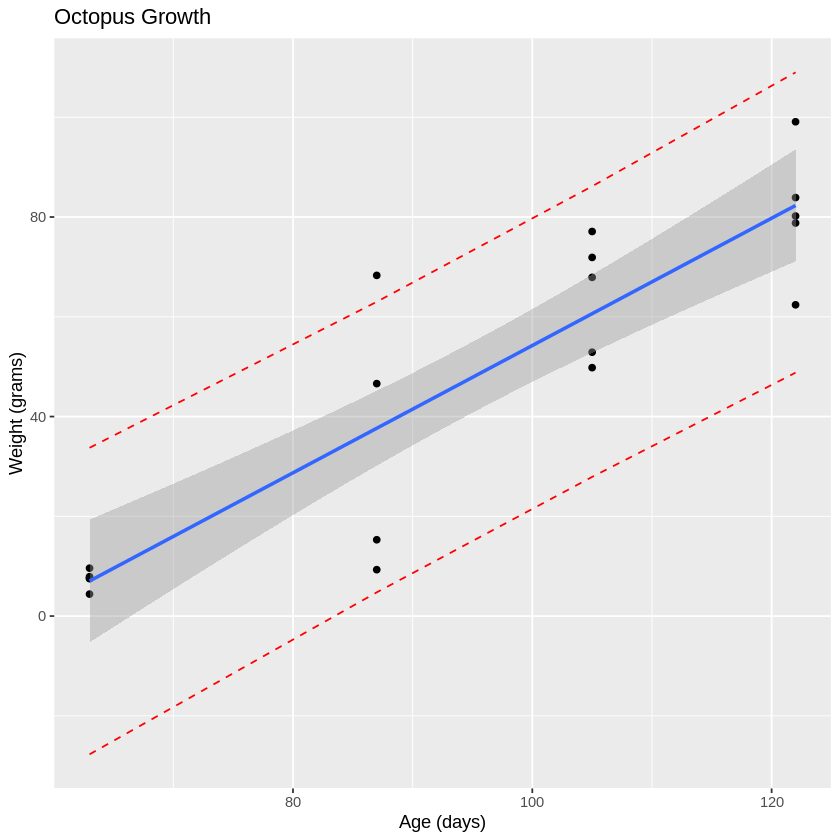

In [44]:
# combine original dataset with prediction intervals
all.preds <- predict(octo.lmod, octo.data.reduced, interval = "prediction", level = 0.95)
octo.full <- merge(octo.data.reduced, all.preds, by.x = 0, by.y = 0) # merge on row names (indices)

(octo.plot <- ggplot(data = octo.full, aes(x = age, y = weight)) +
                    geom_point() +
                    labs(title = "Octopus Growth", x = "Age (days)", y = "Weight (grams)") +
                    geom_smooth(method = lm, se = TRUE) +
                    geom_line(aes(y = lwr), color = "red", linetype = "dashed") +
                    geom_line(aes(y = upr), color = "red", linetype = "dashed"))

In [45]:
# Test Cell
# This cell has hidden test cases that will run after submission.

#### 1. (f) How large can an octopus get? (5 points)

According to [the internet](https://octolab.tv/mexican-four-eyed-octopus/), an octopus of this type can weigh up to $5$kg and has a maximum lifespan of $2$ years, which we can approximate to $730$ days. According to our model, how much would Brian's octopus weigh if it got that old? Store this value in the `brians.old.octopus.weight`variable.

Does this value agrees with the provided weight? Think about potential limitations of our model.

In [48]:
age = data.frame(age = 730)
brians.old.octopus.weight <- predict(octo.lmod, age)

# your code here
print(brians.old.octopus.weight)

      1 
860.946 


In [49]:
# Test Cell
# This cell has hidden test cases that will run after submission.